In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
from copy import deepcopy

import algorithms
import classifiers

In [5]:
def generate_data1(N, t, rv_params):
    """
    Generating a high-dimensional dataset with a change point.
    
    Parameters:
    - N: Total length of the dataset
    - t: Change point
    - rv_params: A list of dictionaries. Each dictionary contains parameters for two normal distributions 
                 (before and after the change point) for each r.v.
                 Example: [{'mu1': 0, 'sigma1': 1, 'mu2': 5, 'sigma2': 2}, ...]
    
    Returns:
    - data: A 2D numpy array where each row corresponds to an r.v. and each column corresponds to a data point.
    """
    
    data = []
    
    for params in rv_params:
        before_change = np.random.normal(params['mu1'], params['sigma1'], t)
        after_change = np.random.normal(params['mu2'], params['sigma2'], N - t)
        rv_data = np.concatenate([before_change, after_change])
        data.append(rv_data)
    
    return np.array(data)

# Example usage:
N = 1000
t = 700
rv_params = [
    {'mu1': 0, 'sigma1': 1, 'mu2': 5, 'sigma2': 2},
    {'mu1': 3, 'sigma1': 1, 'mu2': 2, 'sigma2': 2},
    {'mu1': -2, 'sigma1': 2, 'mu2': 0, 'sigma2': 1},
    {'mu1': 5, 'sigma1': 2, 'mu2': -3, 'sigma2': 1},
    {'mu1': 0, 'sigma1': 0.5, 'mu2': -2, 'sigma2': 1.5},
]

data = generate_data1(N, t, rv_params)
print(data)

[[-0.19642097  0.47817792 -0.83976689 ...  4.68614599  2.12589218
   4.4979079 ]
 [ 2.8225652   4.16363677  3.32490008 ... -1.25598999  4.30497259
  -0.67292985]
 [-0.38039342 -2.72263815 -1.52388239 ... -2.48839393 -1.34625725
   0.36229338]
 [ 3.41767739  4.65146035  2.82752281 ... -3.03966473 -2.71823691
  -3.93124882]
 [-0.53494709  0.64230216  0.01727637 ... -1.92041878 -2.43272048
  -3.30306982]]


In [6]:
import numpy as np

def generate_data2(N, t, dims, mu_start=0, mu_step=1, sigma1=1, mu_shift=5, sigma2=2):
    """
    Generate high-dimensional data with a change point.
    
    Parameters:
    - N: Total length of the dataset
    - t: Change point
    - dims: Number of dimensions (r.v.s)
    - mu_start: Starting mean for the first r.v. for the first distribution
    - mu_step: Increase in mean for each subsequent r.v. for the first distribution
    - sigma1: Standard deviation for the first distribution
    - mu_shift: Shift in mean for the second distribution relative to the first
    - sigma2: Standard deviation for the second distribution
    
    Returns:
    - data: A 2D numpy array where each row corresponds to an r.v. and each column corresponds to a data point.
    """
    
    data = []
    
    for i in range(dims):
        mu1 = mu_start + i * mu_step
        mu2 = mu1 + mu_shift
        
        before_change = np.random.normal(mu1, sigma1, t)
        after_change = np.random.normal(mu2, sigma2, N - t)
        
        rv_data = np.concatenate([before_change, after_change])
        data.append(rv_data)
    
    return np.array(data)

# Example usage:
N = 1000
t = 700
dims = 5

data = generate_data2(N, t, dims)
print(data)

[[-0.33277617 -0.76476118  0.38441797 ...  3.96852954  3.50660528
   9.13147148]
 [ 2.21088615  1.84978046  0.96223553 ...  8.0756649   3.35894701
   6.25391822]
 [ 2.27779575 -0.0187198   3.55502052 ...  8.36546943 10.08726962
   9.35489143]
 [ 3.50492154  2.75488135  4.82976328 ...  8.32675906  8.23373105
   6.26052981]
 [ 5.06293444  4.04300766  4.39692559 ...  9.55581897 11.68337417
   9.45707873]]


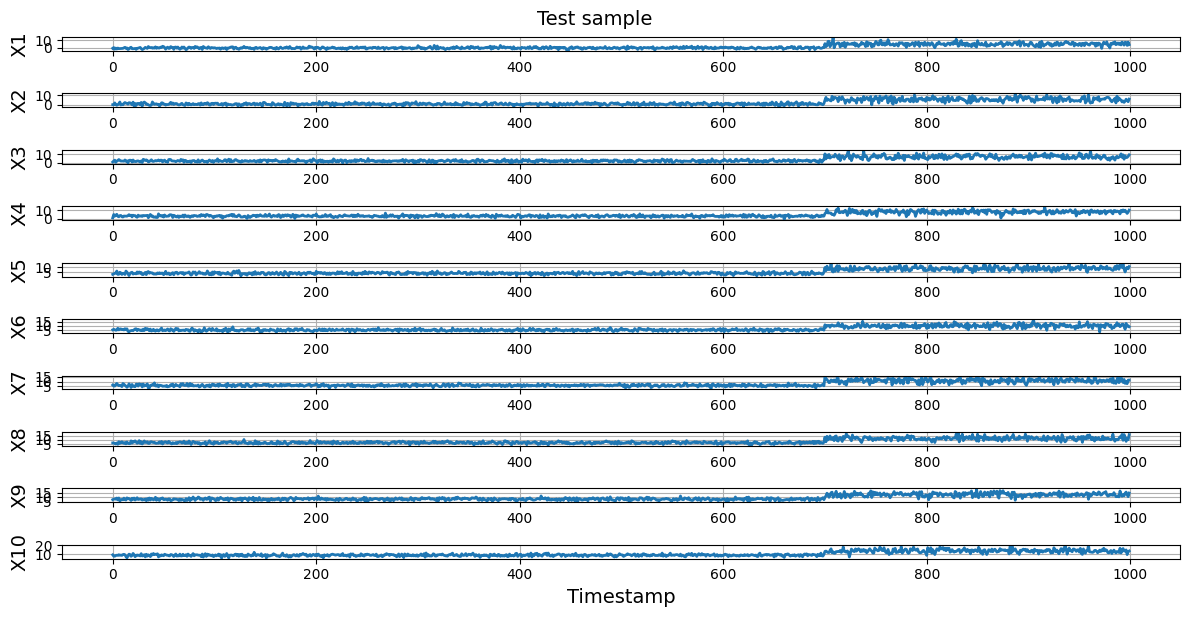

In [8]:
N = 1000
t = 700
dims = 10
X = generate_data2(N, t, dims)

T = np.arange(N)  # Note: The length of T should be N, not len(X)
plt.figure(figsize=(12, 6))

# Plot each dimension separately
for i in range(dims):
    plt.subplot(dims, 1, i+1)
    plt.plot(T, X[i], linewidth=2)
    plt.ylabel(f'X{i+1}', size=14)
    if i == dims - 1:
        plt.xlabel('Timestamp', size=14)
    plt.grid(True)

plt.tight_layout()
plt.suptitle('Test sample', size=14, y=1.02)
plt.show()

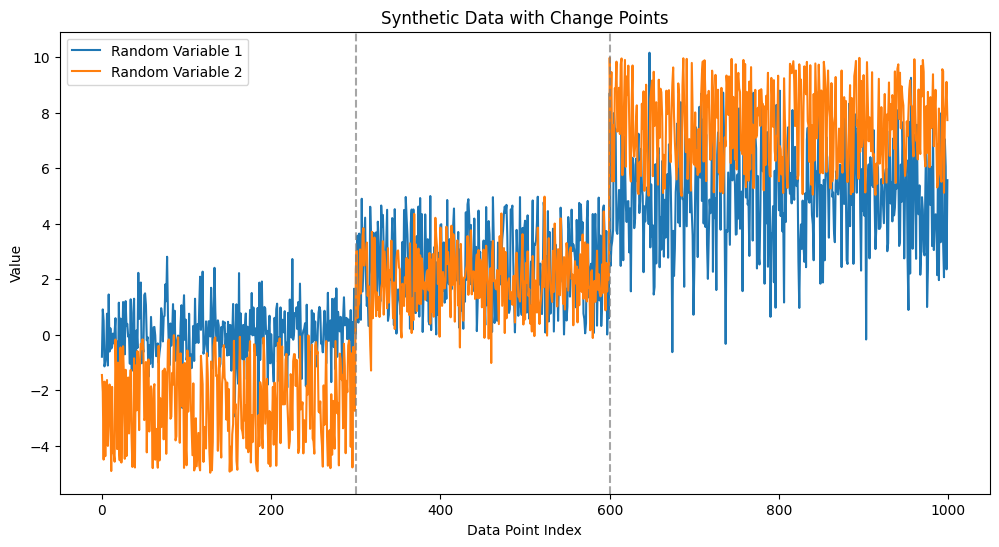

In [1]:
import numpy as np

def generate_synthetic_data_v2(N, change_points_info, rv_params):
    """
    Generate a synthetic dataset with manually specified change points, supporting different distributions and parameters.
    
    Parameters:
    - N (int): Total length of the dataset.
    - change_points_info (dict): A dictionary specifying 'indices' (list of change point indices) and 'count' (number of change points).
    - rv_params (list): A nested list where each sub-list corresponds to a random variable (r.v.) and contains
                        dictionaries with keys 'dist' (distribution name) and distribution parameters for each segment.
    
    Returns:
    - np.ndarray: A 2D numpy array where each row corresponds to an r.v. and each column to a data point.
    """
    # Validate the change point information
    if change_points_info['count'] != len(change_points_info['indices']):
        raise ValueError("The count of change points does not match the number of indices provided.")
    
    # Initialize the dataset array
    data = np.zeros((len(rv_params), N))
    
    # Ensure the list of change point indices starts with 0 and ends with N for iteration
    cps = [0] + change_points_info['indices'] + [N]
    
    # Iterate over each segment defined by consecutive change points
    for i in range(len(cps) - 1):
        start, end = cps[i], cps[i+1]  # Start and end points of the current segment
        
        # Iterate over each random variable
        for rv_index, rv in enumerate(rv_params):
            # Get the parameters for the current r.v. and segment
            segment_params = rv[i]
            
            if segment_params['dist'] == 'normal':
                data[rv_index, start:end] = np.random.normal(segment_params['mu'], segment_params['sigma'], end - start)
            elif segment_params['dist'] == 'uniform':
                data[rv_index, start:end] = np.random.uniform(segment_params['low'], segment_params['high'], end - start)
            # Add more distribution cases as needed
            
    return data

N = 1000
change_points_info = {
    'indices': [300, 600],
    'count': 2
}
rv_params = [
    [  
        {'dist': 'normal', 'mu': 0, 'sigma': 1},
        {'dist': 'uniform', 'low': 0, 'high': 5},
        {'dist': 'normal', 'mu': 5, 'sigma': 2},
    ],
    [  
        {'dist': 'uniform', 'low': -5, 'high': 0},
        {'dist': 'normal', 'mu': 2, 'sigma': 1},
        {'dist': 'uniform', 'low': 5, 'high': 10},
    ]
]

synthetic_data_v2 = generate_synthetic_data_v2(N, change_points_info, rv_params)

import matplotlib.pyplot as plt

def plot_synthetic_data(data, change_points_info):
    """
    Plot the synthetic data with change points highlighted.
    
    Parameters:
    - data (np.ndarray): The synthetic dataset to plot, where each row is a random variable.
    - change_points_info (dict): Information about the change points to highlight them in the plot.
    """
    plt.figure(figsize=(12, 6))
    
    # Plot each random variable
    for i in range(data.shape[0]):
        plt.plot(data[i, :], label=f'Random Variable {i+1}')
    
    # Highlight change points
    for cp in change_points_info['indices']:
        plt.axvline(x=cp, linestyle='--', color='gray', alpha=0.7)
    
    plt.title('Synthetic Data with Change Points')
    plt.xlabel('Data Point Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

plot_synthetic_data(synthetic_data_v2, change_points_info)


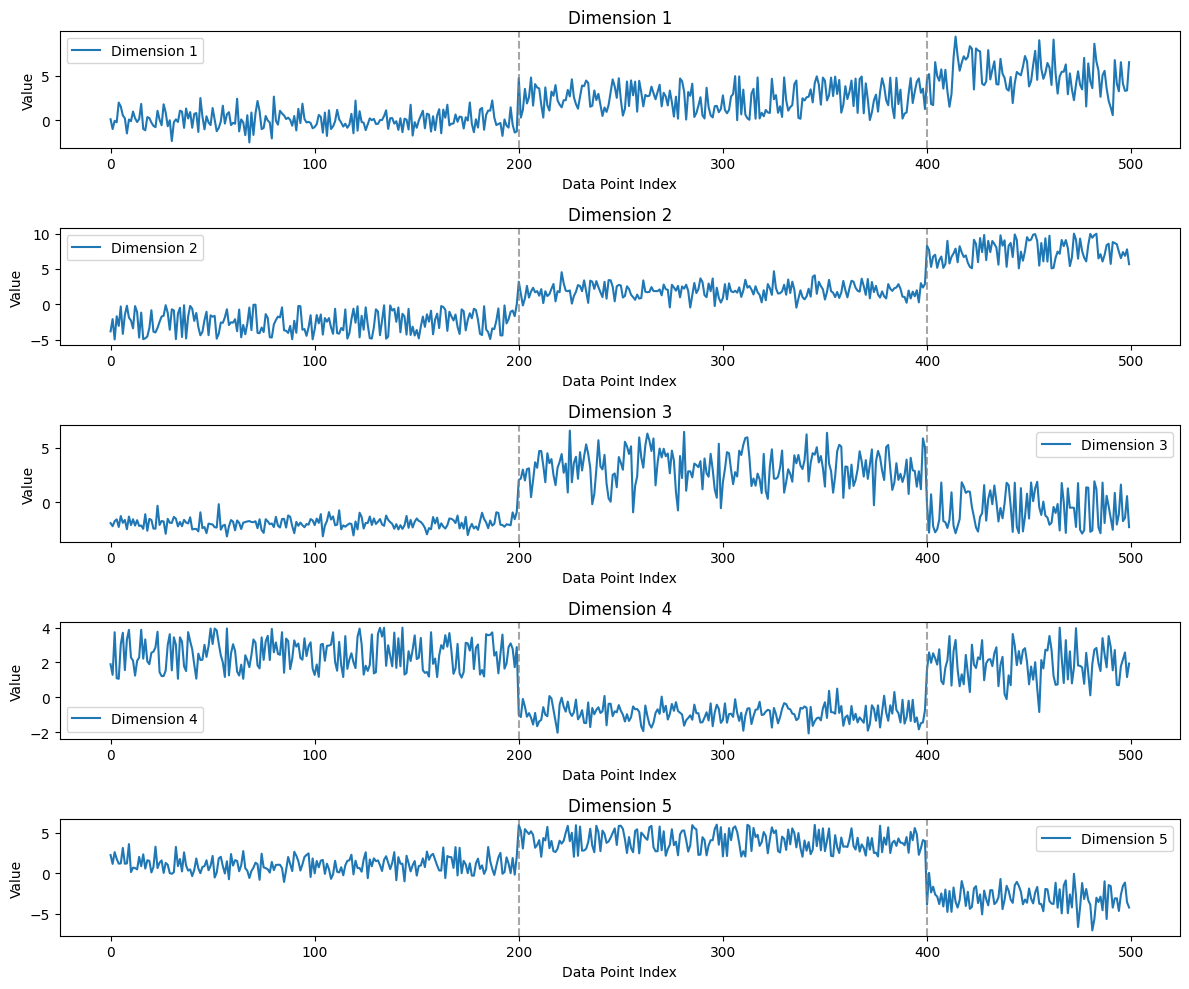

In [2]:
def plot_synthetic_data_separate(data, change_points_info):
    """
    Plot each dimension of the synthetic data on a separate subplot.
    
    Parameters:
    - data (np.ndarray): The synthetic dataset to plot, where each row is a random variable.
    - change_points_info (dict): Information about the change points to highlight them in the plot.
    """
    num_variables = data.shape[0]  # Number of dimensions/random variables
    fig, axes = plt.subplots(num_variables, 1, figsize=(12, 2 * num_variables))  # Create subplots for each dimension
    
    for i, ax in enumerate(axes):
        ax.plot(data[i, :], label=f'Dimension {i+1}')
        
        # Highlight change points
        for cp in change_points_info['indices']:
            ax.axvline(x=cp, linestyle='--', color='gray', alpha=0.7)
        
        ax.set_title(f'Dimension {i+1}')
        ax.set_xlabel('Data Point Index')
        ax.set_ylabel('Value')
        ax.legend()
    
    plt.tight_layout()
    plt.show()

N_5d = 500  
change_points_5d = {
    'indices': [200, 400], 
    'count': 2  
}
rv_params_5d = [
    [  # First dimension
        {'dist': 'normal', 'mu': 0, 'sigma': 1},
        {'dist': 'uniform', 'low': 0, 'high': 5},
        {'dist': 'normal', 'mu': 5, 'sigma': 2},
    ],
    [  # Second dimension
        {'dist': 'uniform', 'low': -5, 'high': 0},
        {'dist': 'normal', 'mu': 2, 'sigma': 1},
        {'dist': 'uniform', 'low': 5, 'high': 10},
    ],
    [  # Third dimension
        {'dist': 'normal', 'mu': -2, 'sigma': 0.5},
        {'dist': 'normal', 'mu': 3, 'sigma': 1.5},
        {'dist': 'uniform', 'low': -3, 'high': 2},
    ],
    [  # Fourth dimension
        {'dist': 'uniform', 'low': 1, 'high': 4},
        {'dist': 'normal', 'mu': -1, 'sigma': 0.5},
        {'dist': 'normal', 'mu': 2, 'sigma': 1},
    ],
    [  # Fifth dimension
        {'dist': 'normal', 'mu': 1, 'sigma': 1},
        {'dist': 'uniform', 'low': 2, 'high': 6},
        {'dist': 'normal', 'mu': -3, 'sigma': 1.5},
    ],
]

synthetic_data_5d = generate_synthetic_data_v2(N_5d, change_points_5d, rv_params_5d)

plot_synthetic_data_separate(synthetic_data_5d, change_points_5d)
